In [1]:
# Dependencies

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import seaborn as sns
import os
import random
random.seed(1) 
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import drive

%pylab inline
%config InlineBackend.figure_formats = ['retina']

import warnings
from scipy import stats
warnings.filterwarnings('ignore')
sns.set()


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.9/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
# Prepare to read the CSV file from Google Drive
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
# Define the link for the CSV file
link = 'https://drive.google.com/file/d/17EmL2q_206QaaiVju6kmF4OwMPXhul8R/view?usp=share_link'
 
# to get the id part of the file
id = link.split("/")[-2]
 
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('diabetes_2021_health_indicators_BRFSS2021.csv') 

# read the file and chunk it to allow for faster processing
df_data=[]
df = pd.read_csv('diabetes_2021_health_indicators_BRFSS2021.csv',encoding='utf-8',chunksize=10000,iterator=True)

for chunk in df:
    df_data.append(chunk)

# Concatenate the chunks
df_data_df=pd.concat(df_data)

In [4]:
# Eliminate any fragmentation by creating a copy of DataFrame
df_bfrss2021 = df_data_df.copy()
df_bfrss2021

,Diabetes,Pre-Diabetic,Afford Costs,Physical Health,Mental Health,Exercise 30 Days,Heart Attack,Heart Disease,Stroke,Lung Disease,...,Gender,Age,Overweight/Obese,Education,Income,Smoker,Binge Drinker,Heavy Drinker,Fruit>1/Day,Veggies>1/Day
0,0,0,0,0,0,0,0,0,0,1,...,2,6,0,2,3,3,0,0,1,1
1,1,0,0,1,1,0,0,1,0,0,...,2,6,1,2,2,4,0,0,1,2
2,1,0,0,1,0,1,0,0,0,0,...,2,5,1,2,5,4,1,0,1,1
3,0,0,0,1,1,0,0,0,0,1,...,1,6,0,3,4,3,0,0,2,2
4,0,0,0,0,0,1,0,0,0,0,...,2,6,1,2,5,3,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242883,1,0,0,1,1,1,0,0,0,0,...,1,6,0,1,2,4,1,0,1,1
242884,0,0,1,1,0,1,0,0,0,1,...,2,2,0,2,3,3,0,0,1,1
242885,0,0,0,1,1,1,0,0,0,0,...,1,4,1,4,6,4,0,0,1,1
242886,0,0,0,1,1,1,0,0,0,0,...,1,6,0,2,4,4,0,0,1,1


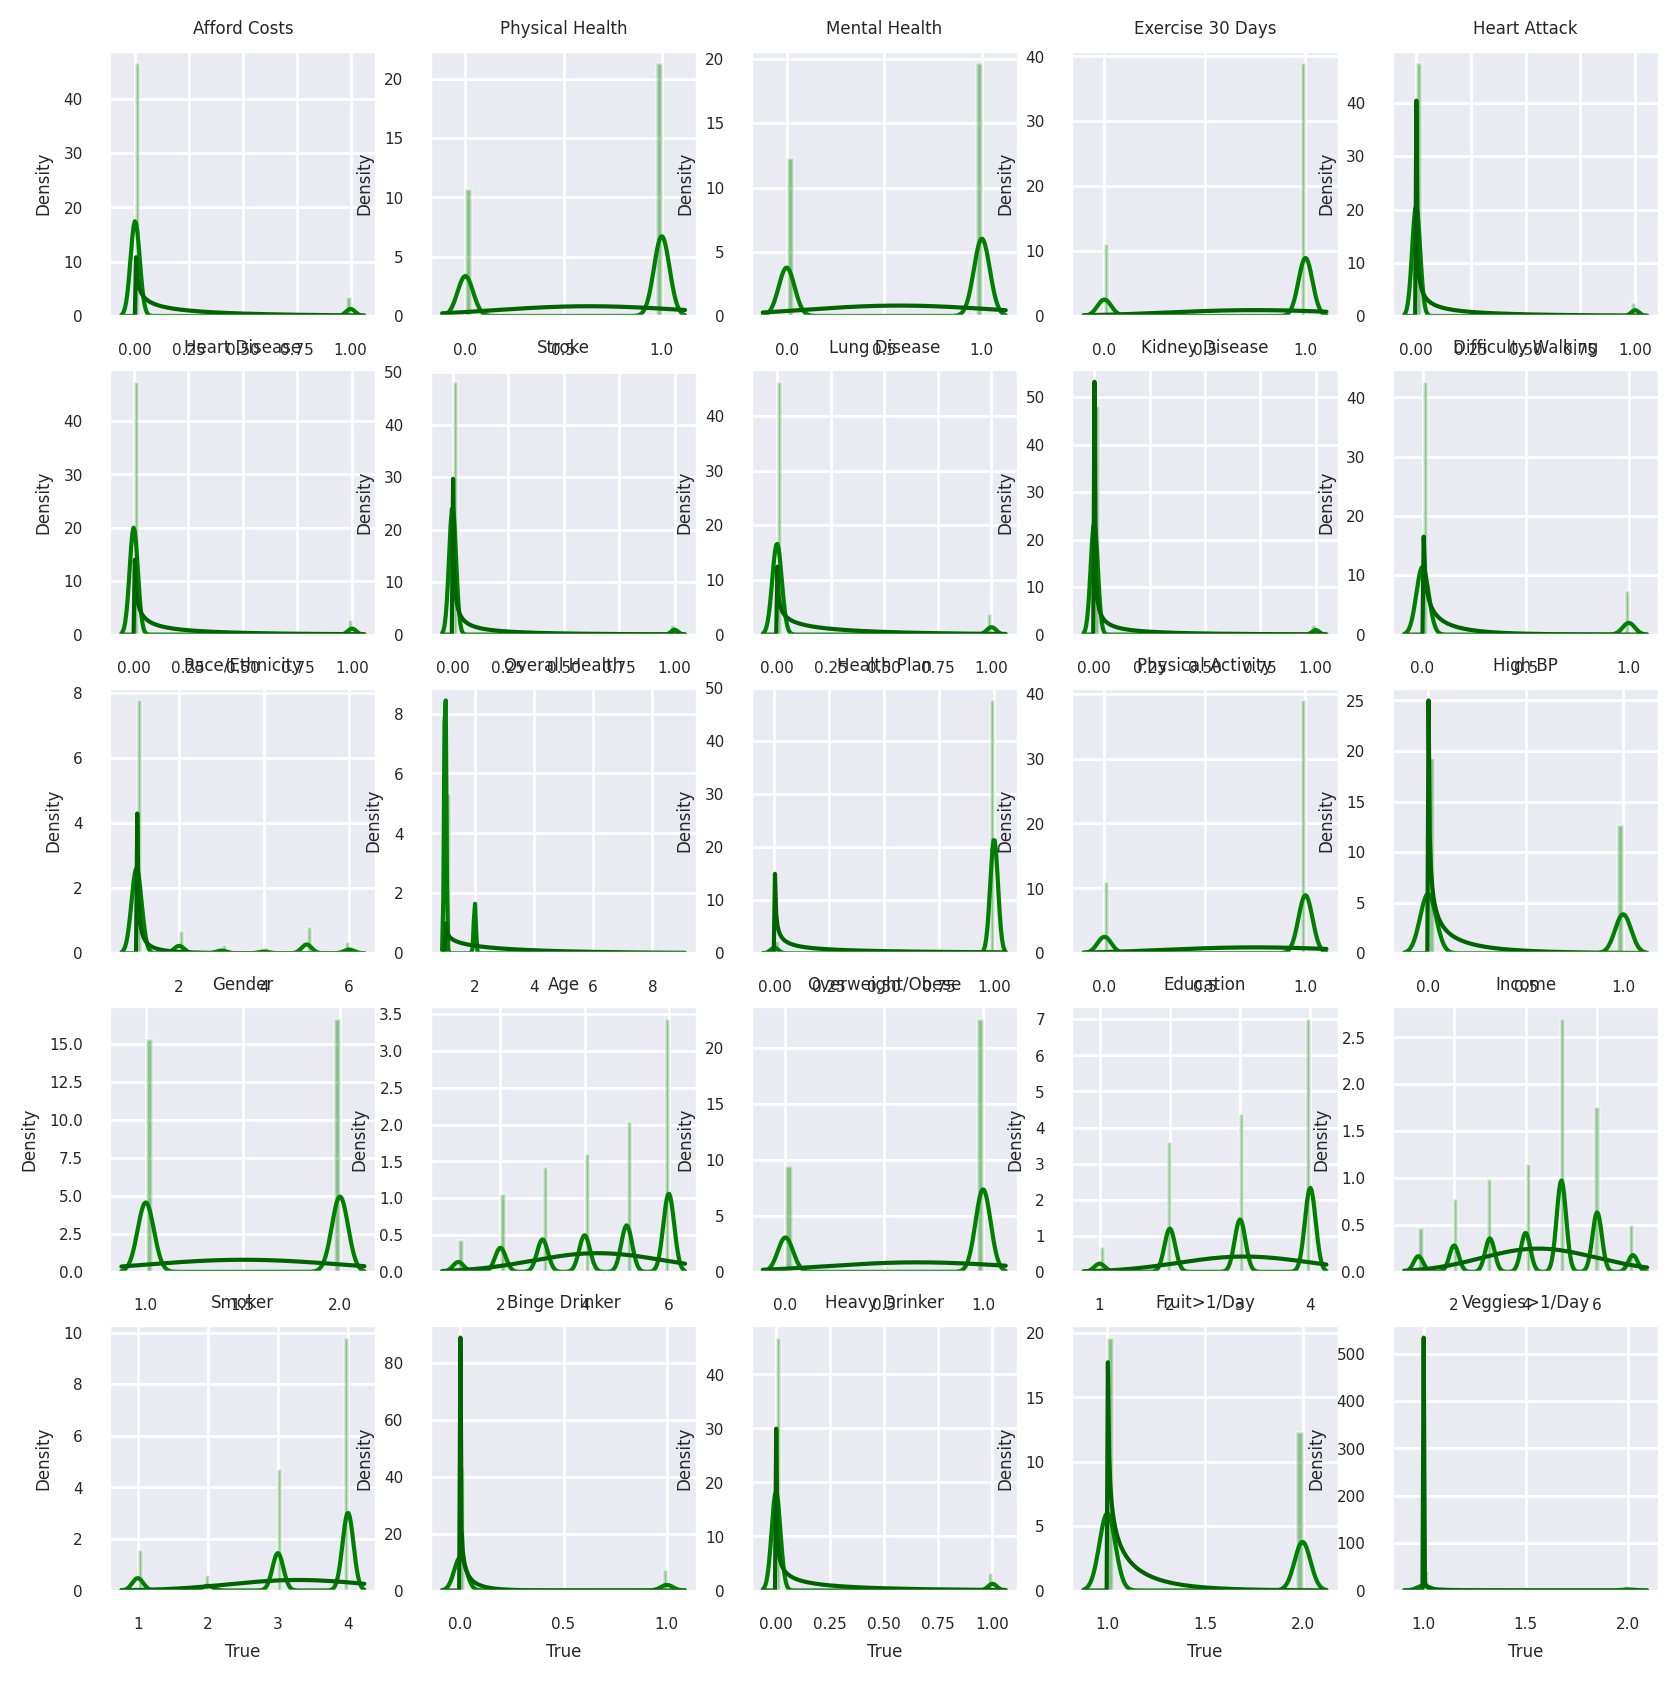

In [67]:
distplot_df=df_bfrss2021.loc[:,['Afford Costs',
                                'Physical Health',
                                'Mental Health',
                                'Exercise 30 Days',
                                'Heart Attack',
                                'Heart Disease',
                                'Stroke',
                                'Lung Disease',
                                'Kidney Disease',
                                'Difficulty Walking',
                                'Race/Ethnicity',
                                'Overall Health',
                                'Health Plan',
                                'Physical Activity',
                                'High BP',
                                'Gender',
                                'Age',
                                'Overweight/Obese',
                                'Education',
                                'Income',
                                'Smoker',
                                'Binge Drinker',
                                'Heavy Drinker',
                                'Fruit>1/Day',
                                'Veggies>1/Day']]

sns.set(font_scale=0.5)
fig = plt.figure(figsize=(10, 10))
for i, column in enumerate(distplot_df.columns, 1):
    f=plt.subplot(5,5,i)
    sns.distplot(distplot_df[column], color="green",fit_kws={"color":"darkgreen"},fit=stats.gamma,kde=True,axlabel=True)
    plt.title(column)

In [83]:
# Create a copy of DataFrame
df_feature_uni = df_data_df.copy()

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X = df_feature_uni.iloc[:,1:27] #independent columns
y = df_feature_uni.iloc[:,0]    #target column i.e price range

#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

                 Specs         Score
15             High BP  10463.343391
10  Difficulty Walking   9159.465353
9       Kidney Disease   6351.972320
17                 Age   5615.521868
6        Heart Disease   5360.916585
5         Heart Attack   5039.800395
7               Stroke   2481.226817
20              Income   2443.889477
8         Lung Disease   2214.954127
22       Binge Drinker   1702.764358


[0.01319746 0.01837349 0.02567053 0.03750291 0.00754139 0.0180345
 0.01889718 0.0159276  0.02265798 0.02240041 0.03402306 0.07296402
 0.04449413 0.0086283  0.00895082 0.06318374 0.03291856 0.08354674
 0.0222688  0.09797132 0.14947129 0.08726513 0.01153526 0.00832352
 0.04104606 0.03320581]


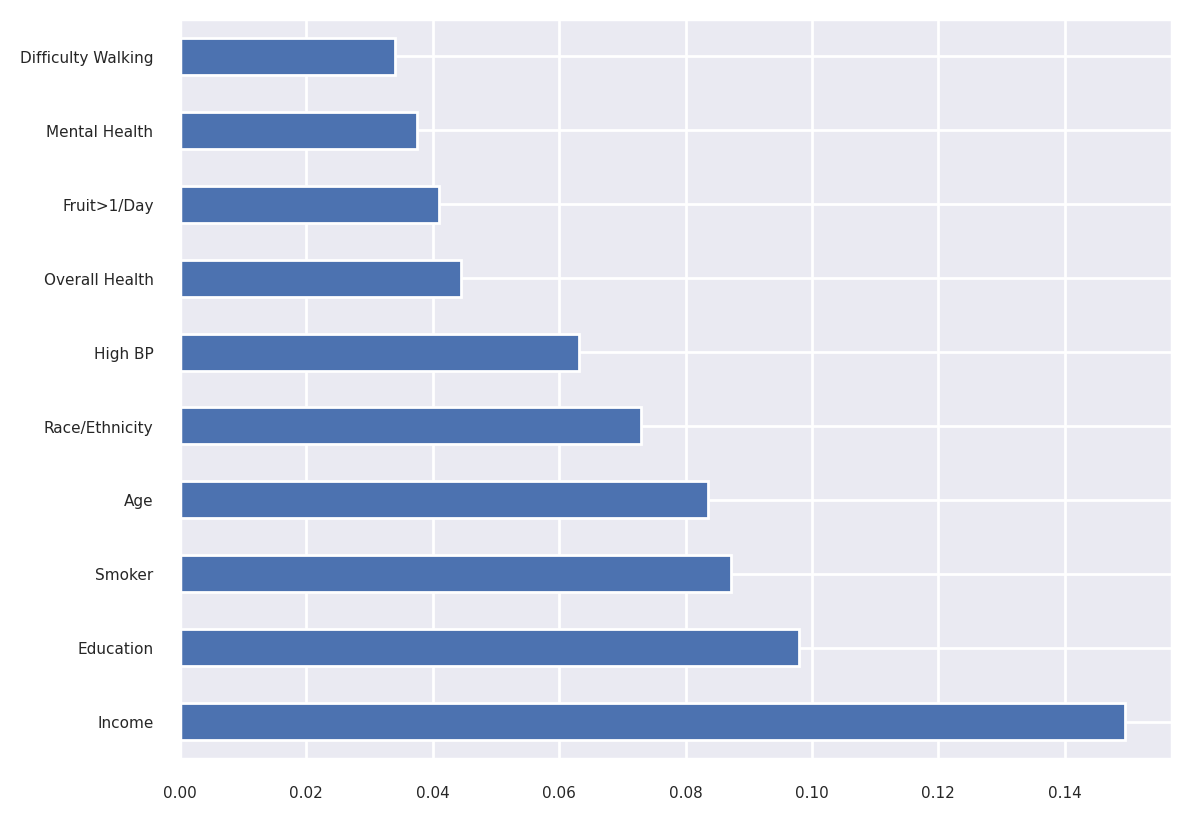

In [84]:
# Create a copy of DataFrame
df_feature_fi = df_data_df.copy()

X = df_feature_fi.iloc[:,1:27] #independent columns
y = df_feature_fi.iloc[:,0]    #target column i.e price range

from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers

#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

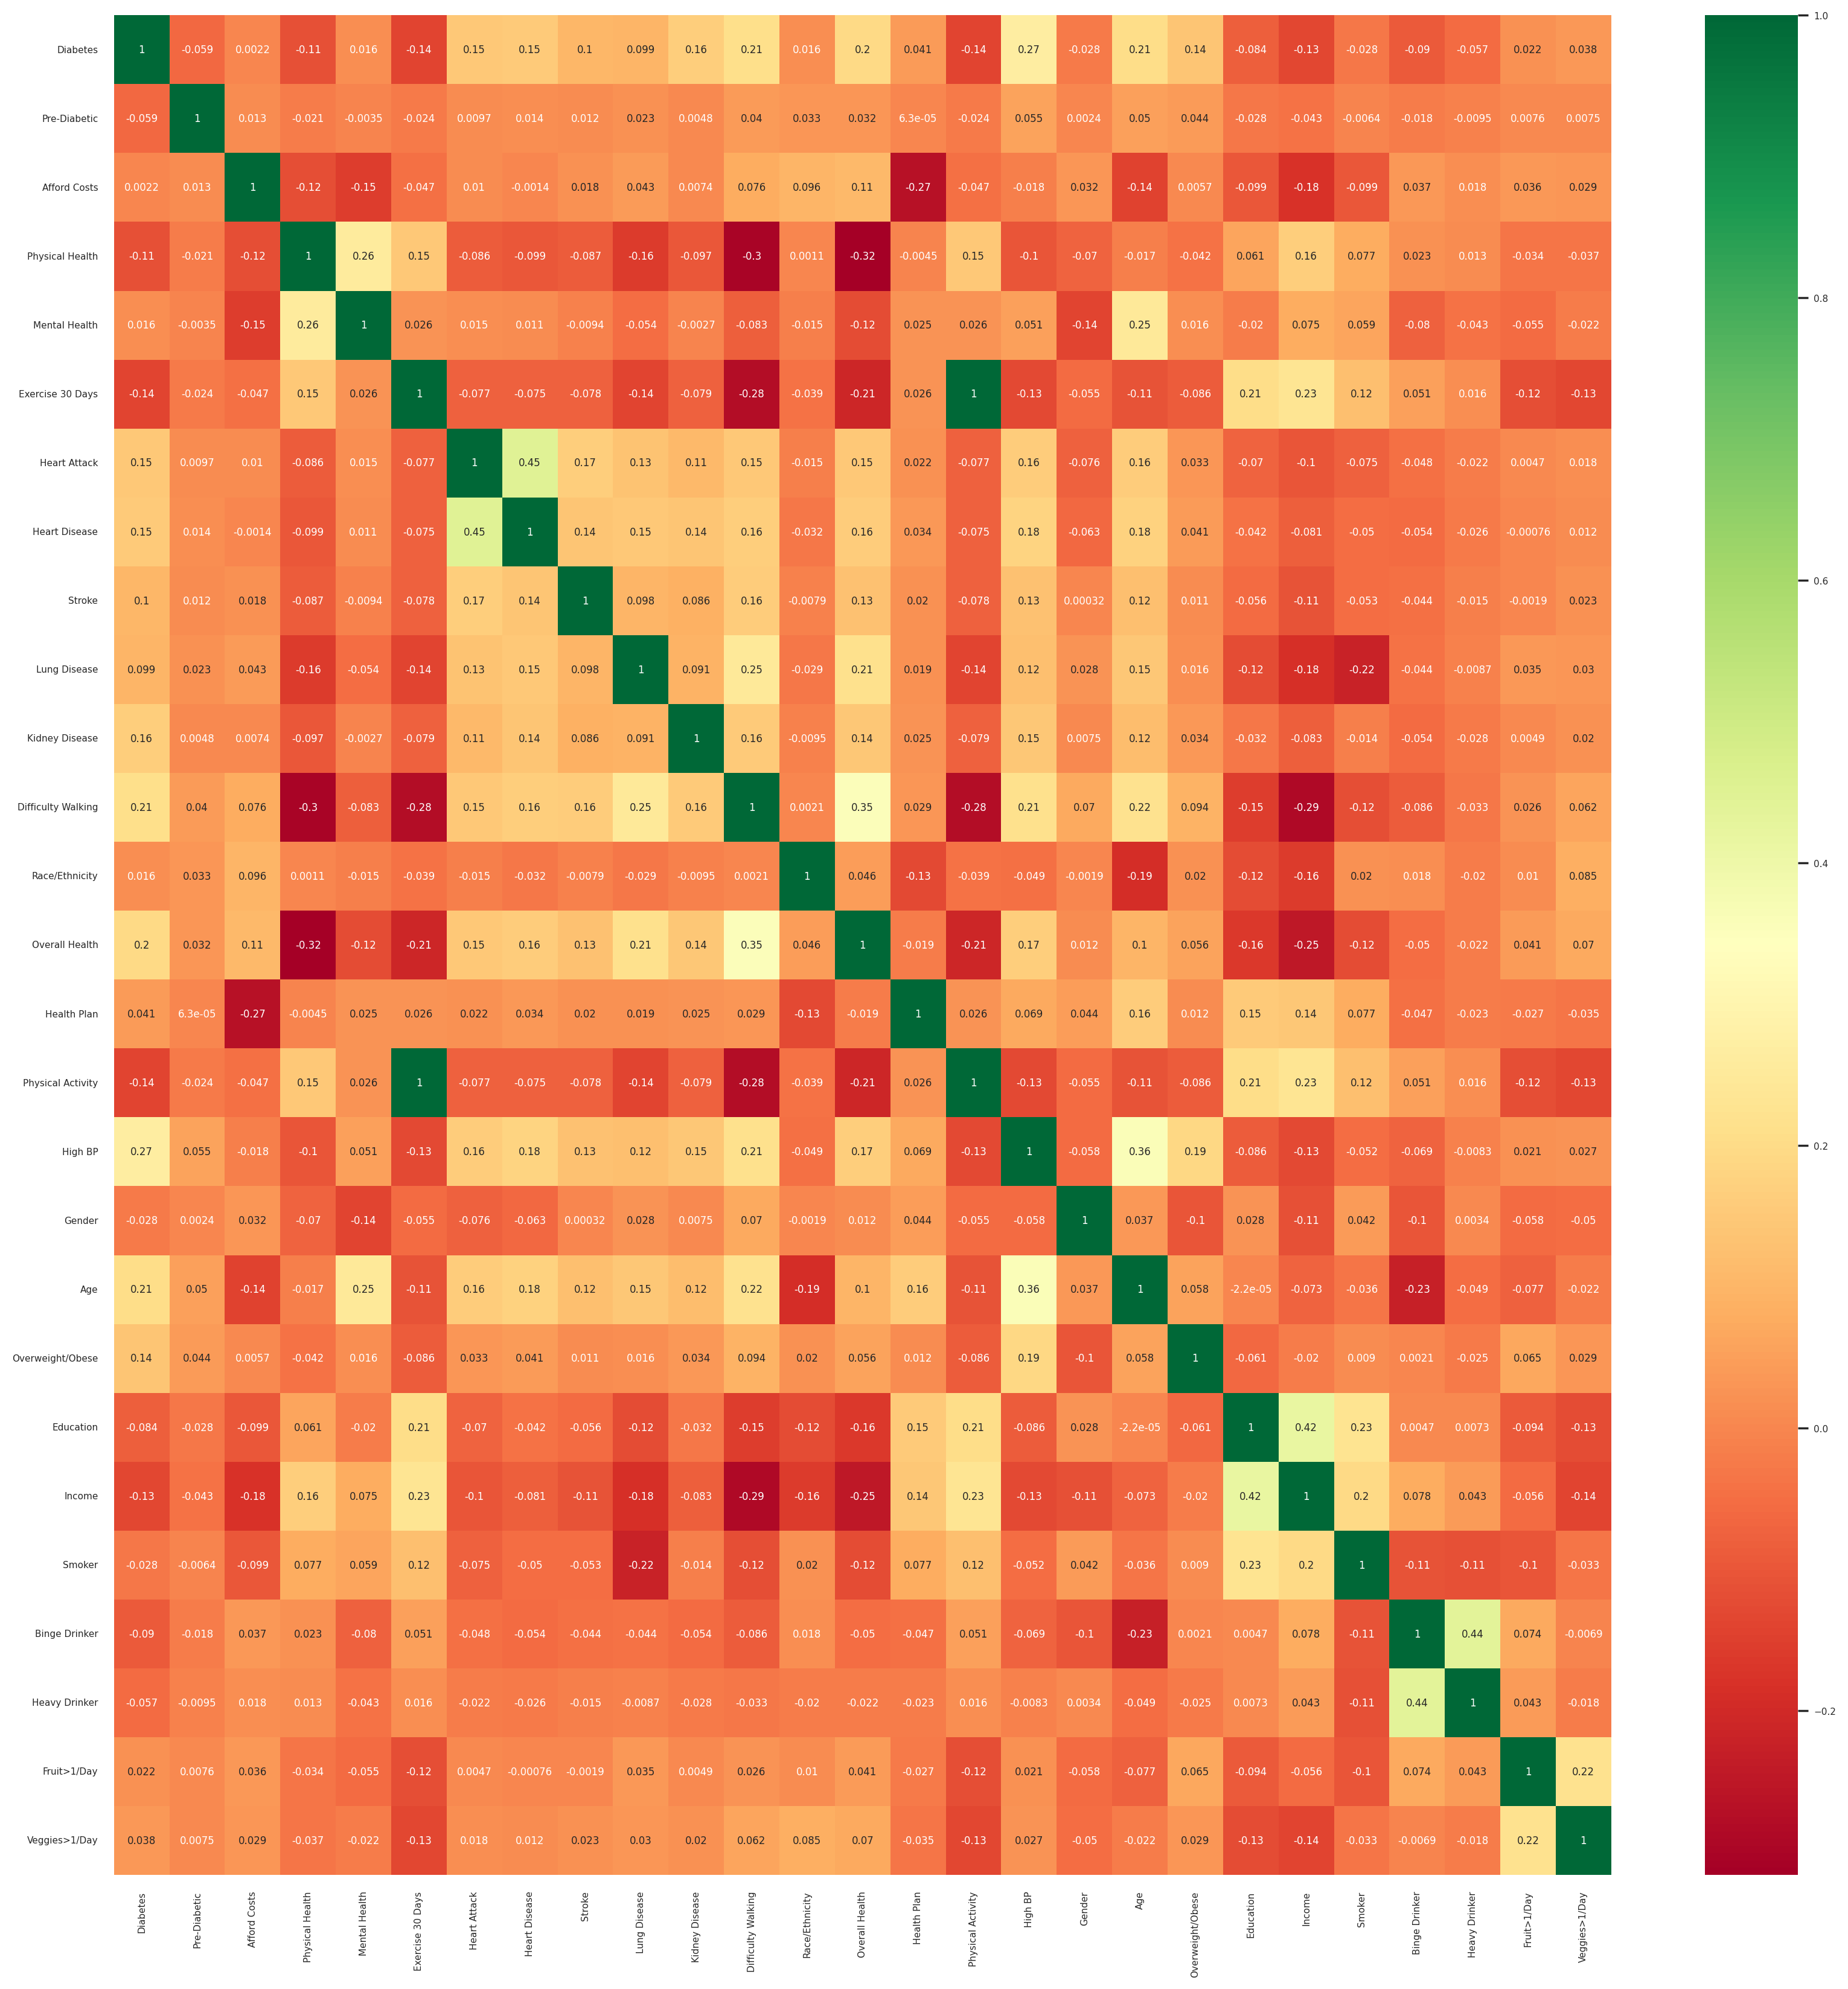

In [85]:
# Create a copy of DataFrame
df_feature_corr = df_data_df.copy()

X = df_feature_corr.iloc[:,1:27] #independent columns
y = df_feature_corr.iloc[:,0]    #target column i.e price range

#get correlations of each features in dataset
corrmat = df_feature_corr.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))

#plot heat map
g=sns.heatmap(df_feature_corr[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [114]:
# Create a copy of DataFrame
df_feature_rfe = df_data_df.copy()

# Feature Extraction with RFE
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

columns = ['Diabetes','Pre-Diabetic','Afford Costs','Physical Health','Mental Health','Exercise 30 Days','Heart Attack','Heart Disease',
           'Stroke','Lung Disease','Kidney Disease','Difficulty Walking','Race/Ethnicity','Overall Health',
           'Health Plan','Physical Activity','High BP','Gender','Age','Overweight/Obese','Education',
           'Income', 'Smoker', 'Binge Drinker','Heavy Drinker','Fruit>1/Day','Veggies>1/Day']

array = df_feature_rfe[columns].values
X = array[:,1:27]
Y = array[:,0]

# feature extraction
model = LogisticRegression(solver='lbfgs')
rfe = RFE(estimator=model, n_features_to_select=3)
fit = rfe.fit(X, Y)
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

Num Features: 3
Selected Features: [ True False False False False False False False False  True False False
 False False False  True False False False False False False False False
 False False]
Feature Ranking: [ 1 20 14 24 12  5 10 11 19  1  2 16  6 15  8  1 13  9  3 21 18 23  4  7
 17 22]


In [137]:
# Create a copy of DataFrame
df_feature_pca = df_data_df.copy()

from sklearn.decomposition import PCA

columns_pca = ['Diabetes','Pre-Diabetic','Afford Costs','Physical Health','Mental Health','Exercise 30 Days','Heart Attack','Heart Disease',
           'Stroke','Lung Disease','Kidney Disease','Difficulty Walking','Race/Ethnicity','Overall Health',
           'Health Plan','Physical Activity','High BP','Gender','Age','Overweight/Obese','Education',
           'Income', 'Smoker', 'Binge Drinker','Heavy Drinker','Fruit>1/Day','Veggies>1/Day']

# load data
array = df_feature_pca[columns_pca].values
X = array[:,1:27]
Y = array[:,0]

# feature extraction
pca = PCA(n_components=2)
pca.fit(X)

# summarize components
print("Explained Variance: %s" % pca.explained_variance_ratio_)
print(pca.components_)

Explained Variance: [0.26371341 0.23892019]
[[ 0.00482923  0.02778211 -0.04901178 -0.01552602 -0.0708873   0.01525213
   0.01263998  0.01314366  0.03217968  0.01048822  0.06586155  0.32106812
   0.07131759 -0.02032584 -0.0708873   0.04678656  0.0276418   0.10407438
   0.01225527 -0.29274783 -0.86430457 -0.15197246 -0.01611547 -0.0056128
   0.02146707  0.03705421]
 [-0.00284667  0.02274239  0.00992576 -0.06456367  0.02688558 -0.0204046
  -0.02411345 -0.01363684 -0.02539832 -0.01362481 -0.0474952   0.49294253
  -0.02440908 -0.02288748  0.02688558 -0.10565132 -0.01138218 -0.85194859
  -0.01394382 -0.01195667  0.06079242  0.04186267  0.04425098  0.00567734
   0.01957602  0.01060293]]


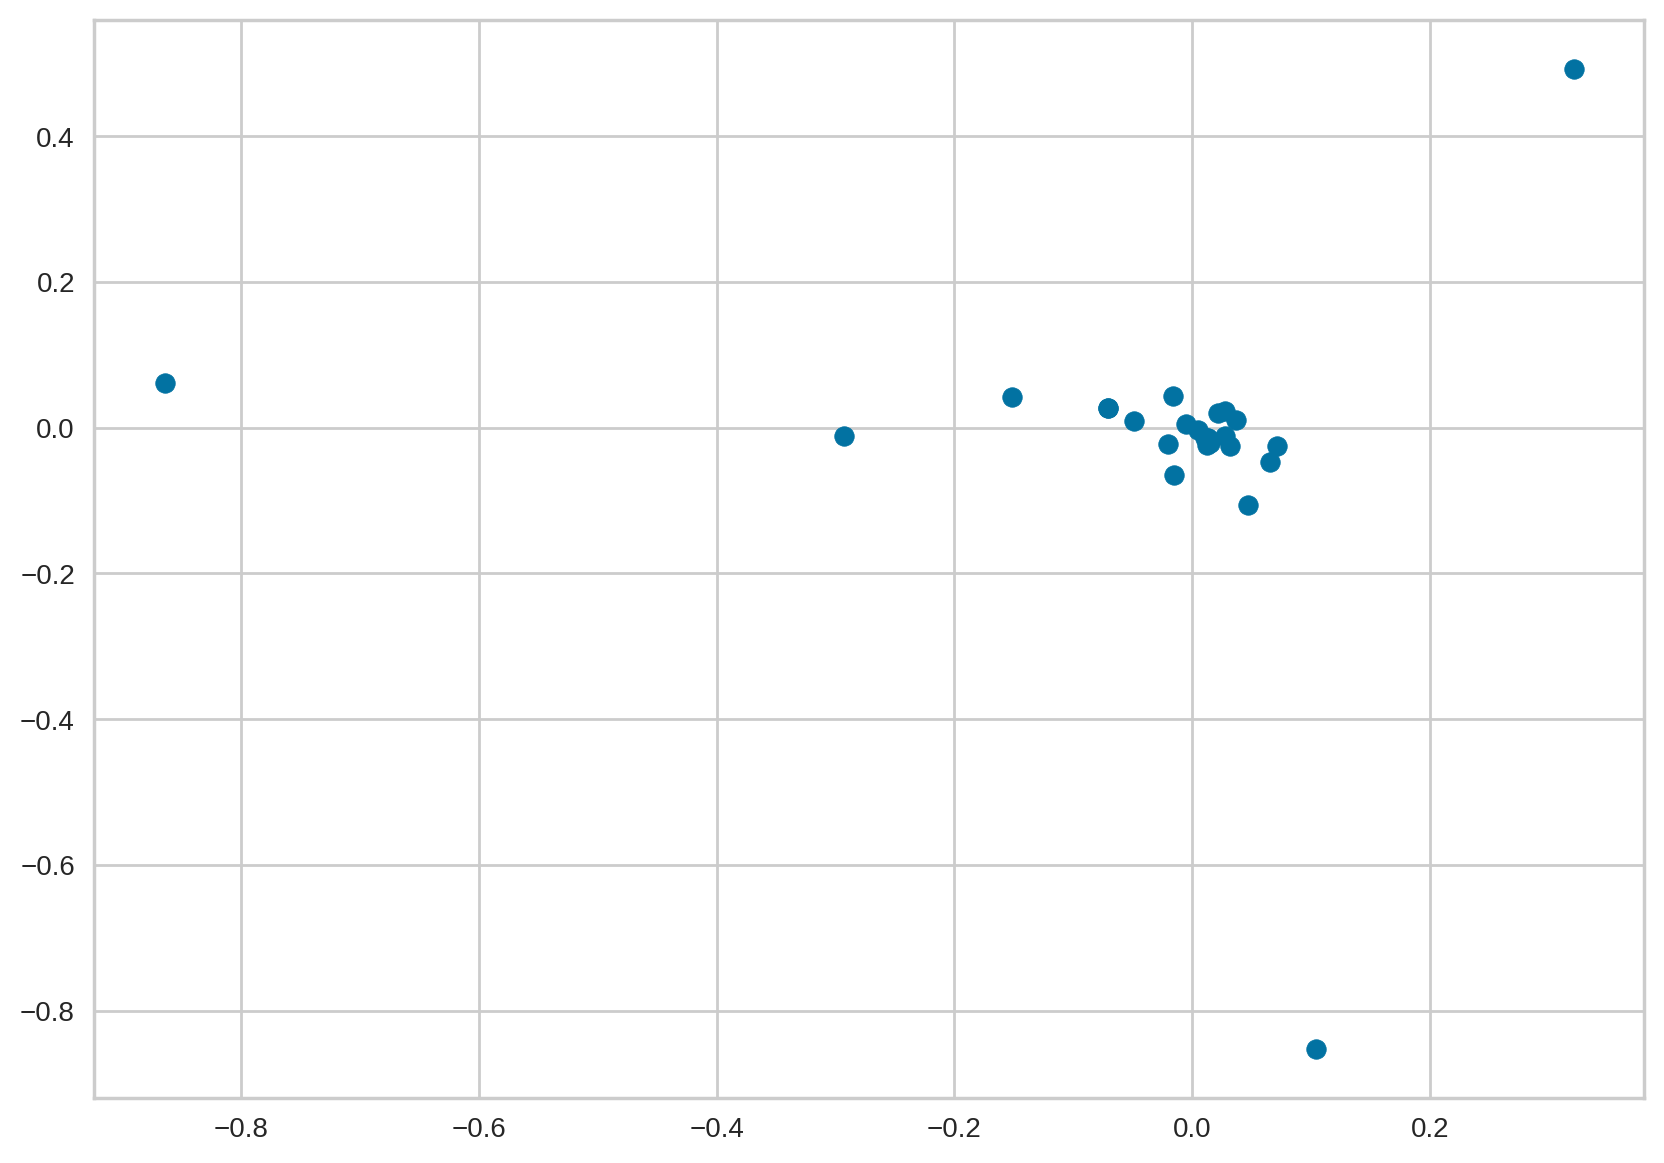

In [169]:
PCA1 = [0.00482923,  0.02778211, -0.04901178, -0.01552602, -0.0708873,   0.01525213,
   0.01263998,  0.01314366,  0.03217968,  0.01048822,  0.06586155,  0.32106812,
   0.07131759, -0.02032584, -0.0708873,   0.04678656,  0.0276418,   0.10407438,
   0.01225527, -0.29274783, -0.86430457, -0.15197246, -0.01611547, -0.0056128,
   0.02146707,  0.03705421]
PCA2 = [-0.00284667,  0.02274239,  0.00992576, -0.06456367,  0.02688558, -0.0204046,
  -0.02411345, -0.01363684, -0.02539832, -0.01362481, -0.0474952,   0.49294253,
  -0.02440908, -0.02288748,  0.02688558, -0.10565132, -0.01138218, -0.85194859,
  -0.01394382, -0.01195667,  0.06079242,  0.04186267,  0.04425098,  0.00567734,
   0.01957602,  0.01060293]

plt.scatter(x=PCA1, y=PCA2)